In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
from src.efficient_kan import KAN

/root/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F
from torch.nn import init
from tqdm import tqdm

In [9]:
import numpy as np
import random
from typing import Tuple, List, Optional

In [45]:
config = {}
config['input_dim'] = 1024*16
config['batch_size'] = 64
config['hidden_layers'] = [1024, 256]
config['lr'] = 1e-3
config['gamma'] = 0.9
config['period'] = 2

In [6]:
class kae_dataset(Dataset):
    def __init__(self, num_data=100, input_dim=128):
        super(kae_dataset, self).__init__()
        self.num_data = num_data
        self.target = []
        for i in range(num_data):
            scale = random.random()
            phase_left = random.random() + 0.1
            phase_right = random.random() + 0.1
            x=np.arange(-phase_left*2*np.pi*config['period'],phase_right*2*np.pi*config['period'],(phase_right*2*np.pi+phase_left*2*np.pi)*config['period']/input_dim)
            x=x.reshape(len(x),1)
            y=scale * np.sin(x)
            self.target.append(y)

    def __getitem__(self, index):
        target = torch.from_numpy(self.target[index]).squeeze().unsqueeze(0).to(torch.float32)
        return target

    def __len__(self):
        return len(self.target)

trainset = kae_dataset(10000, config['input_dim'])
valset = kae_dataset(100, config['input_dim'])
trainloader = DataLoader(trainset, batch_size=config['batch_size'], shuffle=True)
valloader = DataLoader(valset, batch_size=config['batch_size'], shuffle=False)

In [33]:
class ResidualVectorQuantizer(nn.Module):
    weight: torch.Tensor
    running_mean: torch.Tensor
    code_count: torch.Tensor

    def __init__(
        self,
        num_quantizers: int,
        num_embeddings: int,
        embedding_dim: int,
        decay: float = 0.99,
        code_replace_threshold: float = 0.0001,
        eps: float = 1e-10,
    ) -> None:
        super().__init__()
        self.num_quantizers = num_quantizers
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.register_buffer("weight", torch.empty(num_quantizers, num_embeddings, embedding_dim))
        self.register_buffer("running_mean", torch.empty(num_quantizers, num_embeddings, embedding_dim))
        self.register_buffer("code_count", torch.empty(num_quantizers, num_embeddings))
        self.decay = decay
        self.eps = eps
        self.code_replace_threshold = code_replace_threshold
        self.reset_parameters()

    def reset_parameters(self) -> None:
        init.uniform_(self.weight)
        self.running_mean[:] = self.weight
        init.ones_(self.code_count)

    @torch.cuda.amp.autocast(enabled=False)
    def forward(self, input: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, List[torch.Tensor]]:
        # input: [..., chennel]
        if self.training:
            # Enabling bitrate scalability with quantizer dropout
            n = random.randrange(1, self.num_quantizers)
        else:
            n = self.num_quantizers
        codes = []
        r = input.type_as(self.running_mean).detach()
        with torch.no_grad():
            for i in range(n):
                w = self.weight[i]
                # r: [..., num_embeddings]
                dist = torch.cdist(r, w)
                k = torch.argmin(dist, axis=-1)
                codes.append(k)
                self._update_averages(i, r, k)
                r = r - F.embedding(k, w)
        quantized = input - r
        commitment_loss = torch.mean(torch.square(input - quantized.detach()))
        self.weight.data[:] = self.running_mean / torch.unsqueeze(self.eps + self.code_count, axis=-1)
        return quantized, torch.stack(codes, input.ndim - 1), commitment_loss

    def dequantize(self, input: torch.Tensor, n: Optional[int] = None) -> torch.Tensor:
        # input: [batch_size, length, num_quantizers]
        if n is None:
            n = input.shape[-1]
        assert 0 < n <= self.num_quantizers
        res = 0
        with torch.no_grad():
            for i in range(n):
                k = input[:, :, i]
                w = self.weight[i]
                res += F.embedding(k, w)
        return res

    def _update_averages(self, i: int, r: torch.Tensor, k: torch.Tensor) -> None:
        # https://arxiv.org/pdf/1906.00446.pdf
        # Generating Diverse High-Fidelity Images with VQ-VAE-2
        # 2.1 Vector Quantized Variational AutoEncode

        # k: [...]
        one_hot_k = F.one_hot(torch.flatten(k), self.num_embeddings).type_as(self.code_count)
        code_count_update = torch.mean(one_hot_k, axis=0)
        self.code_count[i].lerp_(code_count_update, 1 - self.decay)

        # r: [..., embedding_dim]
        r = r.reshape(-1, self.embedding_dim)
        running_mean_update = (one_hot_k.T @ r) / r.shape[0]
        self.running_mean[i].lerp_(running_mean_update, 1 - self.decay)

    @torch.no_grad()
    @torch.cuda.amp.autocast(enabled=False)
    def replace_vectors(self) -> int:
        # https://arxiv.org/pdf/2107.03312.pdf
        # C. Residual Vector Quantizer:

        # The original paper replaces with an input frame randomly
        # sampled within the current batch.
        # Here we replace with random average of running mean instead.
        num_replaced = torch.sum(self.code_count < self.code_replace_threshold).item()
        if num_replaced > 0:
            for i in range(self.num_quantizers):
                mask = self.code_count[i] < self.code_replace_threshold
                # mask: [num_quantizers, num_embeddings]
                w = torch.rand_like(self.code_count[i])
                w /= torch.sum(w)
                self.running_mean[i, mask] = w.type_as(self.running_mean) @ self.running_mean[i]
                self.code_count[i, mask] = w.type_as(self.code_count) @ self.code_count[i]

        return num_replaced

    @torch.no_grad()
    def calc_entropy(self) -> float:
        p = self.code_count / (self.eps + torch.sum(self.code_count, axis=-1, keepdim=True))
        return -torch.sum(torch.log(p) * p).item() / self.num_quantizers
        
class KRVQ(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        input_dim,
        K,
        num_quantizers,
    ):
        super(KRVQ, self).__init__()
        self.layers_hidden = layers_hidden
        self.input_dim = input_dim
        self.K = K
        self.num_quantizers = num_quantizers
        self.encoder = KAN([input_dim, layers_hidden[0], layers_hidden[1]])
        self.RVQ = ResidualVectorQuantizer(num_quantizers=num_quantizers, num_embeddings=K, embedding_dim=layers_hidden[1])
        self.decoder = KAN([layers_hidden[1], layers_hidden[0], input_dim])

    def encode(self, input):
        posterior_dist = self.encoder(input)

        # Split the result into miu and sigma components
        # of the latent Gaussian distribution

        return posterior_dist

    def decode(self, z):
        priori_dist = self.decoder(z)
        return priori_dist

    def forward(self, input, **kwargs):
        encoding = self.encode(input)
        z, codes, codebook_loss = self.RVQ(encoding)
        return self.decode(z), codes, codebook_loss

    def loss_function(self,
                      input, 
                      ouput, 
                      codebook_loss):

        recons_loss = F.mse_loss(ouput, input)

        loss = recons_loss + codebook_loss
        return {'loss': loss,
                'Reconstruction_Loss': recons_loss,
                'codebook_loss':codebook_loss}


In [56]:
# Define model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = KRVQ(layers_hidden=config['hidden_layers'], input_dim=config['input_dim'], K=1024, num_quantizers=8)
model.to(device)
# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=1e-4)
# Define learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=config['gamma'])

# Define loss
criterion = nn.MSELoss()

In [64]:
for epoch in range(10):
    # Train
    model.train()
    with tqdm(trainloader) as pbar:
        for i, targets in enumerate(pbar):
            targets = targets.view(-1, config['input_dim']).to(device)
            optimizer.zero_grad()
            output, _, codebook_loss = model(targets)
            loss = model.loss_function(output, targets, codebook_loss)
            loss['loss'].backward()
            optimizer.step()
            pbar.set_postfix(loss=loss['loss'].item(), recon_loss=loss['Reconstruction_Loss'].item(), codebook_loss=loss['codebook_loss'].item(), lr=optimizer.param_groups[0]['lr'])

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for targets in valloader:
            targets = targets.view(-1, config['input_dim']).to(device)
            output, _, codebook_loss = model(targets)
            loss = model.loss_function(output, targets, codebook_loss)
            val_loss += loss['loss'].item()
            
    val_loss /= len(valloader)

    # Update learning rate
    scheduler.step()

    print(
        f"Epoch {epoch + 1}, Val Loss: {val_loss}"
    )

100%|██████████| 157/157 [00:07<00:00, 19.63it/s, codebook_loss=0.000224, loss=0.117, lr=0.000122, recon_loss=0.116]


Epoch 1, Val Loss: 0.28912200033664703


100%|██████████| 157/157 [00:07<00:00, 19.73it/s, codebook_loss=0.00028, loss=0.154, lr=0.000109, recon_loss=0.154] 


Epoch 2, Val Loss: 0.2850838005542755


100%|██████████| 157/157 [00:07<00:00, 19.74it/s, codebook_loss=0.000302, loss=0.173, lr=9.85e-5, recon_loss=0.173]


Epoch 3, Val Loss: 0.281186506152153


100%|██████████| 157/157 [00:07<00:00, 19.91it/s, codebook_loss=0.000289, loss=0.173, lr=8.86e-5, recon_loss=0.173]


Epoch 4, Val Loss: 0.2761758863925934


100%|██████████| 157/157 [00:07<00:00, 19.92it/s, codebook_loss=0.000191, loss=0.146, lr=7.98e-5, recon_loss=0.146]


Epoch 5, Val Loss: 0.2719113379716873


100%|██████████| 157/157 [00:07<00:00, 20.03it/s, codebook_loss=0.0102, loss=0.174, lr=7.18e-5, recon_loss=0.164]  


Epoch 6, Val Loss: 0.26778267323970795


100%|██████████| 157/157 [00:07<00:00, 20.00it/s, codebook_loss=0.0181, loss=0.223, lr=6.46e-5, recon_loss=0.205]  


Epoch 7, Val Loss: 0.2631540298461914


100%|██████████| 157/157 [00:07<00:00, 20.10it/s, codebook_loss=0.000293, loss=0.136, lr=5.81e-5, recon_loss=0.136]


Epoch 8, Val Loss: 0.25959137082099915


100%|██████████| 157/157 [00:07<00:00, 20.00it/s, codebook_loss=0.0168, loss=0.164, lr=5.23e-5, recon_loss=0.147]  


Epoch 9, Val Loss: 0.2544254660606384


100%|██████████| 157/157 [00:07<00:00, 20.00it/s, codebook_loss=0.000141, loss=0.07, lr=4.71e-5, recon_loss=0.0699]


Epoch 10, Val Loss: 0.24029655754566193


In [31]:
import matplotlib.pyplot as plt

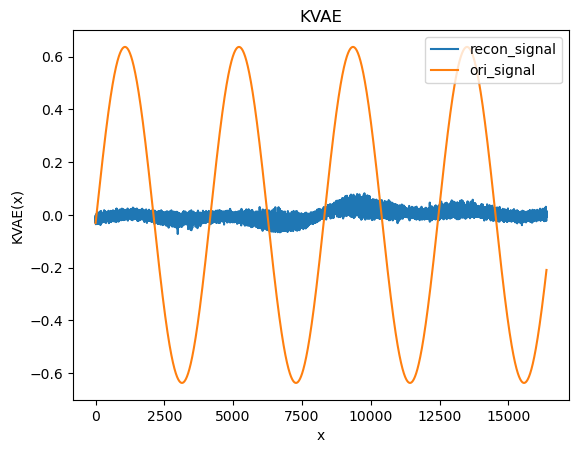

In [68]:
idx = 40
pred = model(trainset[idx].to(device))[0].detach().cpu().numpy()[0]
x = np.linspace(0, config['input_dim'], config['input_dim'])
plt.plot(x, pred, label='recon_signal')
plt.plot(x, trainset[idx][0], label='ori_signal')
plt.xlabel('x')
plt.ylabel('KVAE(x)')
plt.title('KVAE')
plt.legend()
plt.savefig('assets/recon_signal.jpg')
plt.show()